In [4]:
import matplotlib.pyplot as plt
import numpy as np
import os

if os.getcwd().split(os.sep)[-1] == "examples":
    os.chdir('..')
    os.chdir('..')
    os.chdir('..')

# We import the model, stimuli, and the optimal control package
from neurolib.models.fhn import FHNModel
from neurolib.models.hopf import HopfModel
from neurolib.utils.stimulus import ZeroInput
from neurolib.optimal_control import oc_fhn, oc_hopf
from neurolib.optimal_control.oc_utils.plot_oc import plot_oc_network

# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


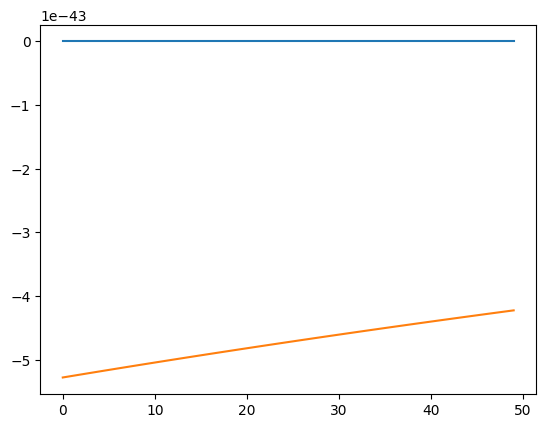

In [18]:
cmat = np.array( [[0., 0.], [1., 0.]] ) # diagonal elements are zero, connection strength is 1 (0.5) from node 0 to node 1 (from node 1 to node 0)
dmat = np.array( [[0., 0.], [0.2, 0.]] ) # delay from 0 to 1, no delay from 1 to 0

#model = FHNModel(Cmat=cmat, Dmat=dmat)
model = FHNModel(Cmat=cmat, Dmat=dmat)

duration, dt = 2000., 0.1
model.params.duration = duration
model.params.dt = dt
model.params.K_gl = 1.
model.params.signalV = 1.
#model.params.x_ou_mean = 1.

model.params.x_ext = np.zeros((1,))
model.params.y_ext = np.zeros((1,))

model.run()

e0 = model.x[0,-1]
e1 = model.x[1,-1]
i0 = model.y[0,-1]
i1 = model.y[1,-1]

model.params["xs_init"] = np.array([[e0, e0, e0],
                                    [e1, e1, e1]])
model.params["ys_init"] = np.array([[i0, i0, i0],
                                     [i1, i1, i1]])

duration = 5.
model.params.duration = duration
time = np.arange(dt, duration+dt, dt)

model.run()
plt.plot(model.x[0,:])
plt.plot(model.x[1,:])
plt.show()

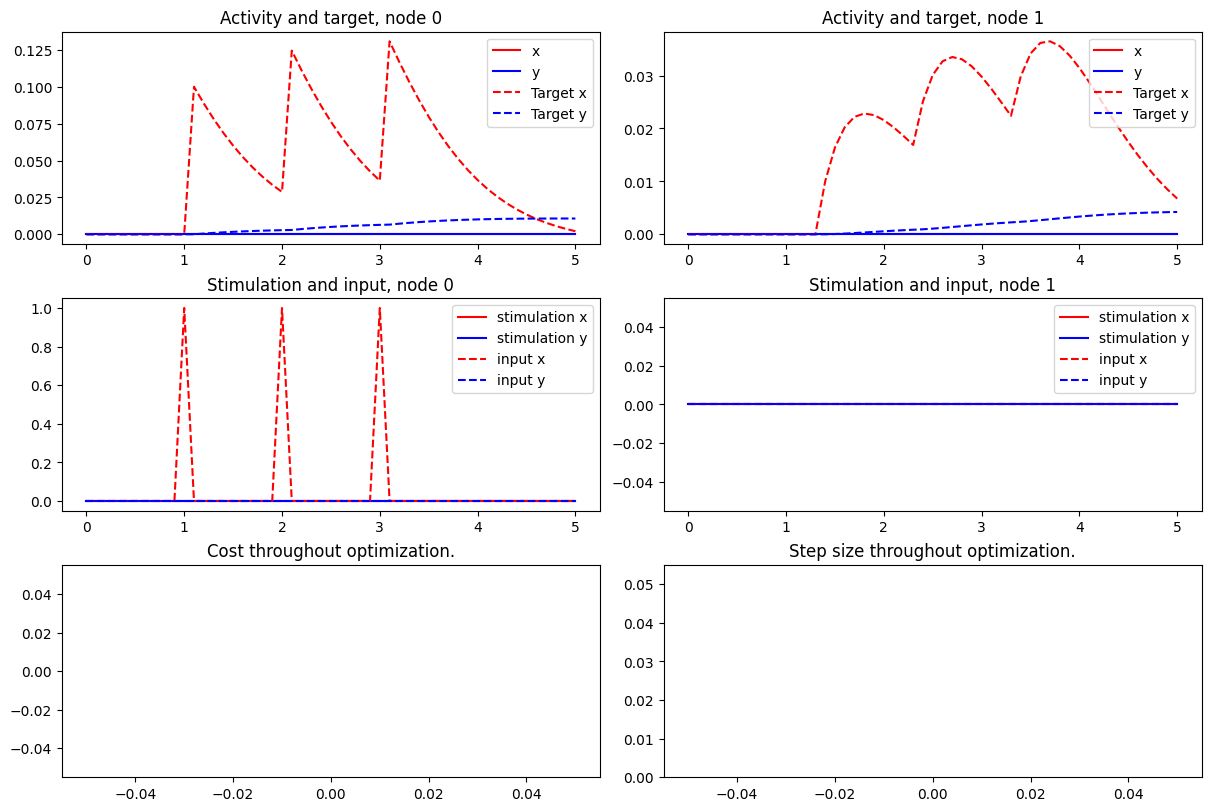

In [19]:
# we define the control input matrix to enable or disable certain channels and nodes
control_mat = np.zeros( (model.params.N, len(model.state_vars)) )
control_mat[0,0] = 1. # only allow inputs in E-channel in node 0

zero_input = ZeroInput().generate_input(duration=duration+dt, dt=dt)
input = np.copy(zero_input)
input[0,10] = 1. # other functions or random values can be used as well
input[0,20] = 1. # other functions or random values can be used as well
input[0,30] = 1. # other functions or random values can be used as well

input_nw = np.concatenate( (np.vstack( [control_mat[0,0] * input, control_mat[0,1] * input] )[np.newaxis,:,:],
                            np.vstack( [control_mat[1,0] * input, control_mat[1,1] * input] )[np.newaxis,:,:]), axis=0)
zero_input_nw = np.concatenate( (np.vstack( [zero_input, zero_input] )[np.newaxis,:,:],
                                 np.vstack( [zero_input, zero_input] )[np.newaxis,:,:]), axis=0)

model.params["x_ext"] = input_nw[:,0,:]
model.params["y_ext"] = input_nw[:,1,:]

model.params["xs_init"] = np.array([[e0, e0, e0],
                                    [e1, e1, e1]])
model.params["ys_init"] = np.array([[i0, i0, i0],
                                     [i1, i1, i1]])

model.run()

# Define the result of the stimulation as target
target = np.concatenate( (np.stack( (model.params["xs_init"][:,-1], model.params["ys_init"][:,-1]), axis=1)[:,:, np.newaxis], np.stack( (model.x, model.y), axis=1)), axis=2)

# Remove stimuli and re-run the simulation
model.params["x_ext"] = zero_input_nw[:,0,:]
model.params["y_ext"] = zero_input_nw[:,0,:]
model.params["xs_init"] = np.array([[e0, e0, e0],
                                    [e1, e1, e1]])
model.params["ys_init"] = np.array([[i0, i0, i0],
                                     [i1, i1, i1]])

model.run()

# combine initial value and simulation result to one array
state =  np.concatenate( (np.stack( (model.params["xs_init"][:,-1], model.params["ys_init"][:,-1]), axis=1)[:,:, np.newaxis], np.stack( (model.x, model.y), axis=1)), axis=2)

plot_oc_network(model.params.N, duration, dt, state, target, zero_input_nw, input_nw)

Compute control for a deterministic system
Cost in iteration 0: 0.0011922315337219614
Cost in iteration 1: 0.0011885338635955916
Cost in iteration 2: 0.0011811559270511955
Cost in iteration 10: 7.280327310566509e-05
Final cost : 7.280327310566509e-05


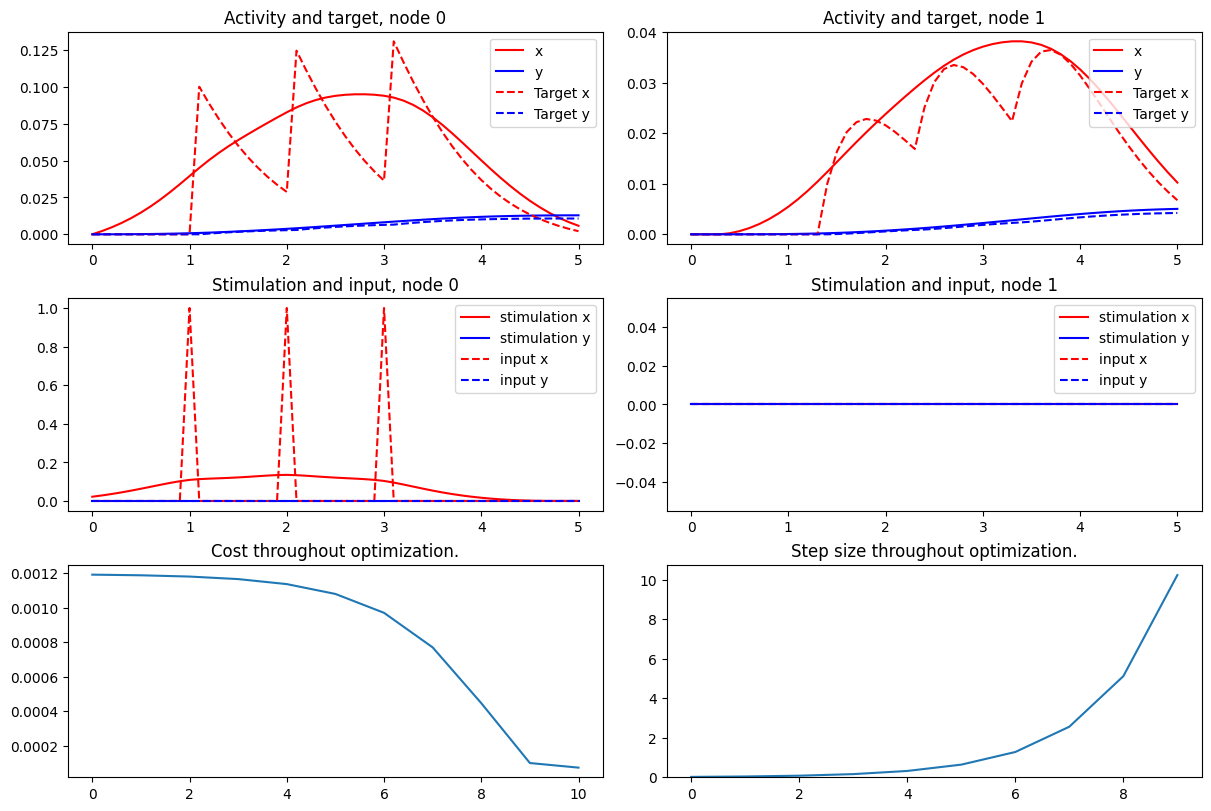

In [20]:
prec_mat = np.zeros( (model.params.N, len(model.output_vars)) )
prec_mat[1,0] = 1. # only measure in y-channel in node 1

model_controlled = oc_fhn.OcFhn(model, target, w_p=1, w_2=0, print_array=[1,2,10,50,100,200,300,400,500], control_matrix=control_mat, precision_matrix=prec_mat)

model_controlled.step = 1e-2
model_controlled.optimize(10)

state = model_controlled.get_xs()
control = model_controlled.control

plot_oc_network(model.params.N, duration, dt, state, target, control, input_nw, model_controlled.cost_history, model_controlled.step_sizes_history)


Compute control for a deterministic system
Cost in iteration 0: 5.592896172480184e-07
Cost in iteration 1: 5.590013851036271e-07
Cost in iteration 2: 5.587320745146265e-07
Cost in iteration 10: 5.567471071671309e-07
Cost in iteration 50: 5.468705877865127e-07
Cost in iteration 100: 5.350032242094673e-07
Cost in iteration 200: 5.124529571837354e-07
Cost in iteration 300: 4.914506742162494e-07
Cost in iteration 400: 4.718336500650938e-07
Cost in iteration 500: 4.5345958955396905e-07
Final cost : 2.6984599773157874e-07


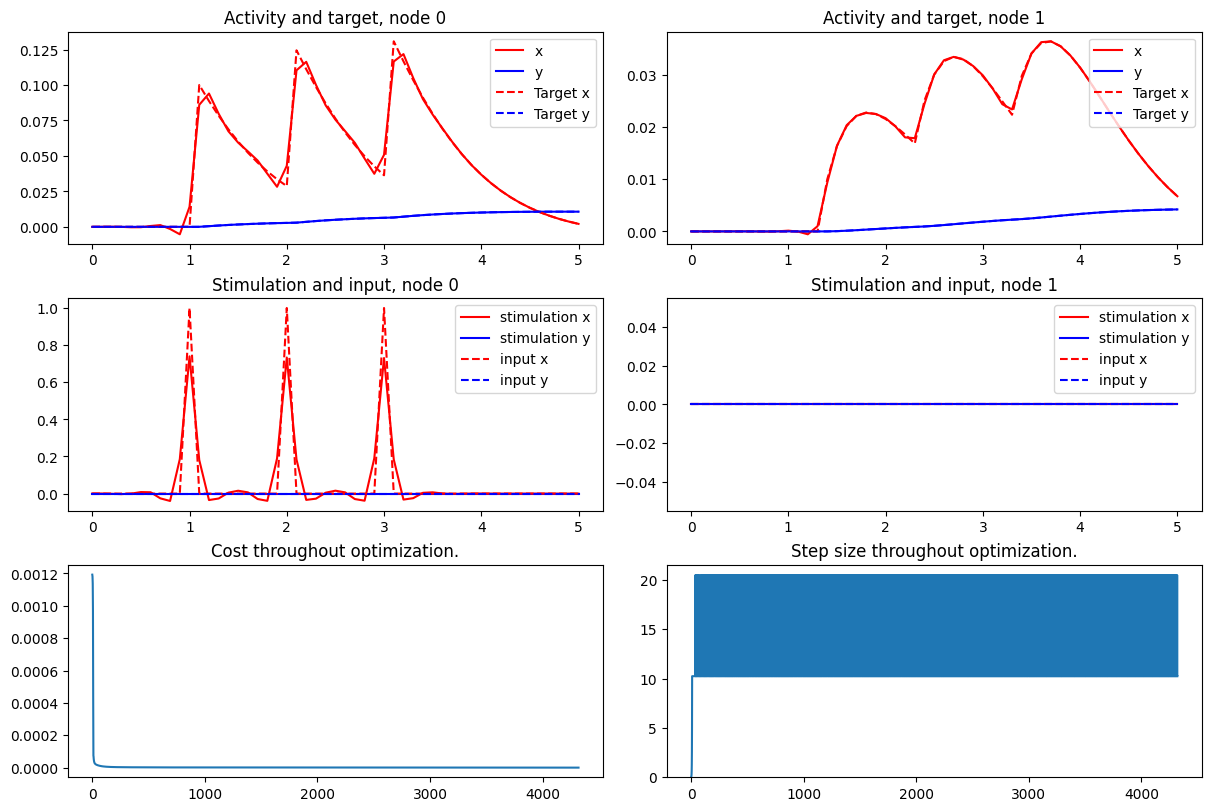

In [27]:
# Do another 100 iterations if you want to.
# Repeated execution will c
# continue with further 100 iterations.
model_controlled.optimize(2000)
state = model_controlled.get_xs()
control = model_controlled.control
plot_oc_network(model.params.N, duration, dt, state, target, control, input_nw, model_controlled.cost_history, model_controlled.step_sizes_history)